In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
address = "https://raw.githubusercontent.com/Jaeik-Jeong/RLES/main/"

data_price = pd.read_csv(address+'price.csv', index_col=0)
data_train_csv = pd.DataFrame(data_price['Price'][:1000])
data_val_csv   = pd.DataFrame(data_price['Price'][1000:1500])
data_test_csv  = pd.DataFrame(data_price['Price'][1500:2000])

In [3]:
# Data Preprocessing

Battery_Size = 1 #p.u.

max_price = max(data_price['Price'])

size_train0 = len(data_train_csv)
size_val0   = len(data_val_csv)
size_test0  = len(data_test_csv)

price_train = list(data_train_csv['Price']/max_price)
price_val = list(data_val_csv['Price']/max_price)
price_test = list(data_test_csv['Price']/max_price)

In [4]:
# Agent

n_layers         = 2
in_size          = 2
hidden_size      = 64
out_size         = 1
T_horizon        = 128
learning_rate    = 0.001
K_epoch          = 3
gamma            = 0.99
lmbda            = 0.95
eps_clip         = 0.1
C_value          = 1
var              = 0.1**2

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.fc_s  = nn.Linear(in_size, hidden_size)
        self.rnn   = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc_pi = nn.Linear(hidden_size, out_size)
        self.fc_v  = nn.Linear(hidden_size, 1)

    def pi(self, x, hidden):
        x = F.relu(self.fc_s(x))
        x = x.view(1, -1, hidden_size)
        x, hidden = self.rnn(x, hidden)
        pi = self.fc_pi(x)
        pi = pi.view(-1, out_size)
        return pi, hidden

    def v(self, x, hidden):
        x = F.relu(self.fc_s(x))
        x = x.view(1, -1, hidden_size)
        x, hidden = self.rnn(x, hidden)
        v = self.fc_v(x)
        v = v.view(-1, 1)
        return v

In [5]:
# Environment

E_max   = Battery_Size
P_max   = E_max
tdelta  = 0.5
soc_min = 0.1
soc_max = 0.9
a0 = -1.031; a1 = 35; a2 = 3.685; a3 = 0.2156; a4 = 0.1178; a5 = 0.3201
b0 = 0.1463; b1 = 30.27; b2 = 0.1037; b3 = 0.0584; b4 = 0.1747; b5 = 0.1288
c0 = 0.1063; c1 = 62.49; c2 = 0.0437; d0 = 0.0712; d1 = 61.4; d2 = 0.0288
N = 130*215*E_max/0.1
beta = 10/max_price

class Env():
    def __init__(self, data):
        self.data_imb = data
        self.state = []

    def reset(self):
        imb = self.data_imb[0]
        E = E_max/2
        state = [[imb, E]]
        self.state = state
        return state

    def step(self, action):
        imb = self.data_imb[len(self.state)]

        E = self.state[-1][-1]
        soc = E/E_max
        Voc = a0*np.exp(-a1*soc) + a2 + a3*soc - a4*soc**2 + a5*soc**3
        Rs  = b0*np.exp(-b1*soc) + b2 + b3*soc - b4*soc**2 + b5*soc**3
        Rts = c0*np.exp(-c1*soc) + c2
        Rtl = d0*np.exp(-d1*soc) + d2
        R   = Rs + Rts + Rtl

        I_cmax = 1000000*(E_max*soc_max - E)/N/(Voc*tdelta)
        I_dmax = 1000000*(E - E_max*soc_min)/N/(Voc*tdelta)
        p_cmax = N*(Voc*I_cmax + I_cmax**2*R)
        p_dmax = N*(Voc*I_dmax - I_dmax**2*R)

        P_cmax = p_cmax/1000000; P_dmax = p_dmax/1000000
        P_c = min(max(-action[0]*E_max, 0), P_max, P_cmax)
        P_d = min(max(action[0]*E_max,  0), P_max, P_dmax)
        p_c = 1000000*P_c/N; p_d = 1000000*P_d/N

        I_c = -(Voc - np.sqrt(Voc**2 + 4*R*p_c))/(2*R)
        I_d = (Voc - np.sqrt(Voc**2 - 4*R*p_d))/(2*R)
        if not np.isclose(p_c, 0):
            eff_c = (Voc*I_c)/p_c; eff_d = 1
            E_prime = E + eff_c*P_c*tdelta
            disp = -P_c
        elif not np.isclose(p_d, 0):
            eff_d = p_d/(Voc*I_d); eff_c = 1
            E_prime = E - (1/eff_d)*P_d*tdelta
            disp = P_d
        else:
            eff_c = 1; eff_d = 1
            E_prime = E
            disp = 0

        revenue = (imb*(P_d-P_c) - beta*(P_c+P_d))*tdelta

        next_state = self.state + [[imb, E_prime]]
        reward = revenue
        done = False
        info = [E, imb*P_c*tdelta, imb*P_d*tdelta, beta*(P_c+P_d)*tdelta, revenue]

        self.state = next_state
        return next_state, reward, done, info

In [6]:
# Environment 2

E_max   = Battery_Size
P_max   = E_max
tdelta  = 0.5
soc_min = 0.1
soc_max = 0.9
a0 = -1.031; a1 = 35; a2 = 3.685; a3 = 0.2156; a4 = 0.1178; a5 = 0.3201
b0 = 0.1463; b1 = 30.27; b2 = 0.1037; b3 = 0.0584; b4 = 0.1747; b5 = 0.1288
c0 = 0.1063; c1 = 62.49; c2 = 0.0437; d0 = 0.0712; d1 = 61.4; d2 = 0.0288
N = 130*215*E_max/0.1
beta = 1/max_price

class Env2():
    def __init__(self, data):
        self.data_imb = data
        self.state = []

    def reset(self):
        imb = self.data_imb[0]
        E = E_max/2
        state = [[imb, E]]
        self.state = state
        return state

    def step(self, action):
        imb = self.data_imb[len(self.state)]

        E = self.state[-1][-1]
        soc = E/E_max
        Voc = a0*np.exp(-a1*soc) + a2 + a3*soc - a4*soc**2 + a5*soc**3
        Rs  = b0*np.exp(-b1*soc) + b2 + b3*soc - b4*soc**2 + b5*soc**3
        Rts = c0*np.exp(-c1*soc) + c2
        Rtl = d0*np.exp(-d1*soc) + d2
        R   = Rs + Rts + Rtl

        I_cmax = 1000000*(E_max*soc_max - E)/N/(Voc*tdelta)
        I_dmax = 1000000*(E - E_max*soc_min)/N/(Voc*tdelta)
        p_cmax = N*(Voc*I_cmax + I_cmax**2*R)
        p_dmax = N*(Voc*I_dmax - I_dmax**2*R)

        P_cmax = p_cmax/1000000; P_dmax = p_dmax/1000000
        P_c = min(max(-action[0]*E_max, 0), P_max, P_cmax)
        P_d = min(max(action[0]*E_max,  0), P_max, P_dmax)
        p_c = 1000000*P_c/N; p_d = 1000000*P_d/N

        I_c = -(Voc - np.sqrt(Voc**2 + 4*R*p_c))/(2*R)
        I_d = (Voc - np.sqrt(Voc**2 - 4*R*p_d))/(2*R)
        if not np.isclose(p_c, 0):
            eff_c = (Voc*I_c)/p_c; eff_d = 1
            E_prime = E + eff_c*P_c*tdelta
            disp = -P_c
        elif not np.isclose(p_d, 0):
            eff_d = p_d/(Voc*I_d); eff_c = 1
            E_prime = E - (1/eff_d)*P_d*tdelta
            disp = P_d
        else:
            eff_c = 1; eff_d = 1
            E_prime = E
            disp = 0

        revenue = (imb*(P_d-P_c) - beta*(P_c+P_d))*tdelta

        next_state = self.state + [[imb, E_prime]]
        reward = (imb*(P_d-P_c) - beta*(P_c+P_d) - abs(P_c-max(-action[0]*E_max,0)) - abs(P_d-max(action[0]*E_max,0)))*tdelta
        done = False
        info = [E, imb*P_c*tdelta, imb*P_d*tdelta, beta*(P_c+P_d)*tdelta, revenue]

        self.state = next_state
        return next_state, reward, done, info

CHA_val: $0.0       DIS_val: $3.972     DEG_val: $0.08      REV_val: $3.892     
CHA_test: $0.0      DIS_test: $4.858    DEG_test: $0.08     REV_test: $4.779    
------------------------------------------------------------------------------------------


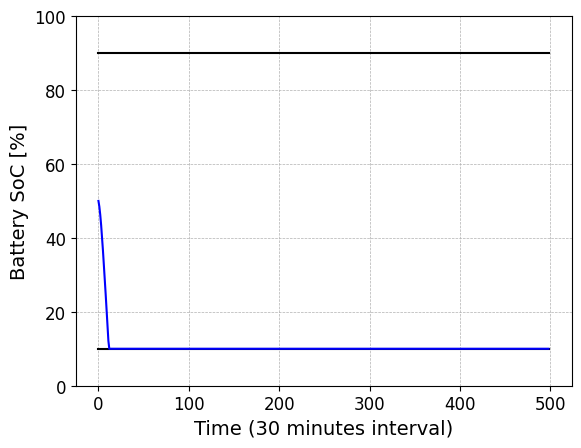

In [7]:
model1_test = LSTM()
model1_test.load_state_dict(torch.load('MODEL1.pt'))
env_train = Env(price_train)
env_val   = Env(price_val)
env_test  = Env(price_test)
bat_val = []; bat_test = []
cha_val = []; cha_test = []
dis_val = []; dis_test = []
deg_val = []; deg_test = []
rev_val = []; rev_test = []

state = env_val.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for k in range(len(env_val.data_imb)-1):
    pi_out, next_history = model1_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_val.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]
    bat_val += [bat]
    cha_val += [cha]
    dis_val += [dis]
    deg_val += [deg]
    rev_val += [revenue]

state = env_test.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for l in range(len(env_test.data_imb)-1):
    pi_out, next_history = model1_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_test.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]
    bat_test += [bat]
    cha_test += [cha]
    dis_test += [dis]
    deg_test += [deg]
    rev_test += [revenue]

CHA_val   = round(max_price*100*np.mean(cha_val),3)
DIS_val   = round(max_price*100*np.mean(dis_val),3)
DEG_val   = round(max_price*100*np.mean(deg_val),3)
REV_val   = round(max_price*100*np.mean(rev_val),3)
CHA_test  = round(max_price*100*np.mean(cha_test),3)
DIS_test  = round(max_price*100*np.mean(dis_test),3)
DEG_test  = round(max_price*100*np.mean(deg_test),3)
REV_test  = round(max_price*100*np.mean(rev_test),3)
print("CHA_val: ${}".format(CHA_val).ljust(20), end="")
print("DIS_val: ${}".format(DIS_val).ljust(20), end="")
print("DEG_val: ${}".format(DEG_val).ljust(20), end="")
print("REV_val: ${}".format(REV_val).ljust(20))
print("CHA_test: ${}".format(CHA_test).ljust(20), end="")
print("DIS_test: ${}".format(DIS_test).ljust(20), end="")
print("DEG_test: ${}".format(DEG_test).ljust(20), end="")
print("REV_test: ${}".format(REV_test).ljust(20))
print("------------------------------------------------------------------------------------------")

fig_model1 = plt.figure()
plt.plot([100*soc_max for _ in range(len(price_test))], 'k', linewidth=1.5)
plt.plot([100*soc_min for _ in range(len(price_test))], 'k', linewidth=1.5)
plt.plot(100*np.array(bat_test), 'blue', linewidth=1.5)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time (30 minutes interval)", fontsize=14)
plt.ylabel("Battery SoC [%]", fontsize=14)
plt.ylim([0, 100])
plt.grid(linestyle='--', linewidth=0.5)
plt.show()
fig_model1.savefig('soc_case1.pdf', bbox_inches='tight', format='pdf', dpi=1000)

CHA_val: $49.468    DIS_val: $72.325    DEG_val: $1.92      REV_val: $20.937    
CHA_test: $40.039   DIS_test: $53.245   DEG_test: $1.691    REV_test: $11.514   
------------------------------------------------------------------------------------------


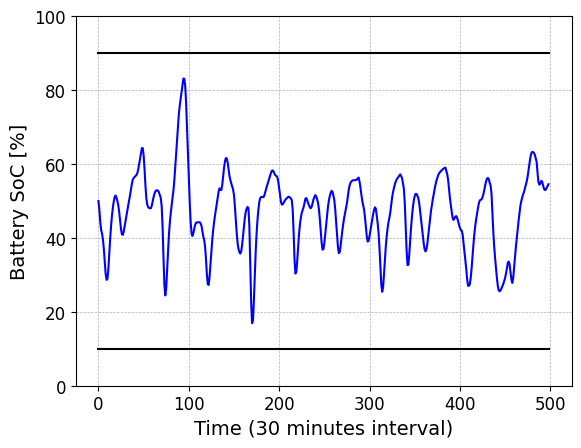

In [8]:
model2_test = LSTM()
model2_test.load_state_dict(torch.load('MODEL2.pt'))
env_train = Env(price_train)
env_val   = Env(price_val)
env_test  = Env(price_test)
bat_val = []; bat_test = []
cha_val = []; cha_test = []
dis_val = []; dis_test = []
deg_val = []; deg_test = []
rev_val = []; rev_test = []

state = env_val.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for k in range(len(env_val.data_imb)-1):
    pi_out, next_history = model2_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_val.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]
    bat_val += [bat]
    cha_val += [cha]
    dis_val += [dis]
    deg_val += [deg]
    rev_val += [revenue]

state = env_test.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for l in range(len(env_test.data_imb)-1):
    pi_out, next_history = model2_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_test.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]
    bat_test += [bat]
    cha_test += [cha]
    dis_test += [dis]
    deg_test += [deg]
    rev_test += [revenue]

CHA_val   = round(max_price*100*np.mean(cha_val),3)
DIS_val   = round(max_price*100*np.mean(dis_val),3)
DEG_val   = round(max_price*100*np.mean(deg_val),3)
REV_val   = round(max_price*100*np.mean(rev_val),3)
CHA_test  = round(max_price*100*np.mean(cha_test),3)
DIS_test  = round(max_price*100*np.mean(dis_test),3)
DEG_test  = round(max_price*100*np.mean(deg_test),3)
REV_test  = round(max_price*100*np.mean(rev_test),3)
print("CHA_val: ${}".format(CHA_val).ljust(20), end="")
print("DIS_val: ${}".format(DIS_val).ljust(20), end="")
print("DEG_val: ${}".format(DEG_val).ljust(20), end="")
print("REV_val: ${}".format(REV_val).ljust(20))
print("CHA_test: ${}".format(CHA_test).ljust(20), end="")
print("DIS_test: ${}".format(DIS_test).ljust(20), end="")
print("DEG_test: ${}".format(DEG_test).ljust(20), end="")
print("REV_test: ${}".format(REV_test).ljust(20))
print("------------------------------------------------------------------------------------------")

fig_model2 = plt.figure()
plt.plot([100*soc_max for _ in range(len(price_test))], 'k', linewidth=1.5)
plt.plot([100*soc_min for _ in range(len(price_test))], 'k', linewidth=1.5)
plt.plot(100*np.array(bat_test), 'blue', linewidth=1.5)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time (30 minutes interval)", fontsize=14)
plt.ylabel("Battery SoC [%]", fontsize=14)
plt.ylim([0, 100])
plt.grid(linestyle='--', linewidth=0.5)
plt.show()
fig_model2.savefig('soc_case2.pdf', bbox_inches='tight', format='pdf', dpi=1000)

CHA_val: $40.441    DIS_val: $70.098    DEG_val: $1.768     REV_val: $27.888    
CHA_test: $37.493   DIS_test: $54.085   DEG_test: $1.714    REV_test: $14.879   
------------------------------------------------------------------------------------------


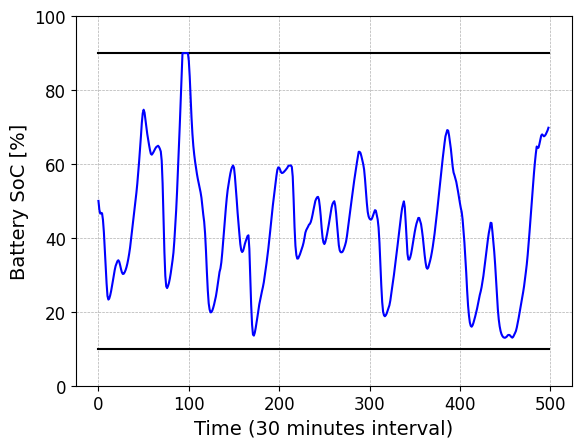

In [9]:
model3_test = LSTM()
model3_test.load_state_dict(torch.load('MODEL3.pt'))
env_train = Env2(price_train)
env_val   = Env2(price_val)
env_test  = Env2(price_test)
bat_val = []; bat_test = []
cha_val = []; cha_test = []
dis_val = []; dis_test = []
deg_val = []; deg_test = []
rev_val = []; rev_test = []

state = env_val.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for k in range(len(env_val.data_imb)-1):
    pi_out, next_history = model3_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_val.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]
    bat_val += [bat]
    cha_val += [cha]
    dis_val += [dis]
    deg_val += [deg]
    rev_val += [revenue]

state = env_test.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for l in range(len(env_test.data_imb)-1):
    pi_out, next_history = model3_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_test.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]
    bat_test += [bat]
    cha_test += [cha]
    dis_test += [dis]
    deg_test += [deg]
    rev_test += [revenue]

CHA_val   = round(max_price*100*np.mean(cha_val),3)
DIS_val   = round(max_price*100*np.mean(dis_val),3)
DEG_val   = round(max_price*100*np.mean(deg_val),3)
REV_val   = round(max_price*100*np.mean(rev_val),3)
CHA_test  = round(max_price*100*np.mean(cha_test),3)
DIS_test  = round(max_price*100*np.mean(dis_test),3)
DEG_test  = round(max_price*100*np.mean(deg_test),3)
REV_test  = round(max_price*100*np.mean(rev_test),3)
print("CHA_val: ${}".format(CHA_val).ljust(20), end="")
print("DIS_val: ${}".format(DIS_val).ljust(20), end="")
print("DEG_val: ${}".format(DEG_val).ljust(20), end="")
print("REV_val: ${}".format(REV_val).ljust(20))
print("CHA_test: ${}".format(CHA_test).ljust(20), end="")
print("DIS_test: ${}".format(DIS_test).ljust(20), end="")
print("DEG_test: ${}".format(DEG_test).ljust(20), end="")
print("REV_test: ${}".format(REV_test).ljust(20))
print("------------------------------------------------------------------------------------------")

fig_model3 = plt.figure()
plt.plot([100*soc_max for _ in range(len(price_test))], 'k', linewidth=1.5)
plt.plot([100*soc_min for _ in range(len(price_test))], 'k', linewidth=1.5)
plt.plot(100*np.array(bat_test), 'blue', linewidth=1.5)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time (30 minutes interval)", fontsize=14)
plt.ylabel("Battery SoC [%]", fontsize=14)
plt.ylim([0, 100])
plt.grid(linestyle='--', linewidth=0.5)
plt.show()
fig_model3.savefig('soc_case3.pdf', bbox_inches='tight', format='pdf', dpi=1000)